# Question 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


from rdkit import Chem
from rdkit import RDLogger
RDLogger.DisableLog("rdApp.*")

     
class Trainer:
    def __init__(self, model, opt_method, learning_rate, batch_size, epoch, l2):
        self.model = model
        if opt_method == "sgdm":
            self.optimizer = torch.optim.SGD(model.parameters(), learning_rate, momentum=0.9)
        elif opt_method == "adam":
            self.optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=l2)
        else:
            raise NotImplementedError("This optimization is not supported")
        
        self.epoch = epoch
        self.batch_size = batch_size
        
    
    def train(self, train_data, draw_curve=True):
        self.encoder = train_data.encoder
        
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        train_loss_list, train_acc_list = [], []
        
        loss_func = nn.CrossEntropyLoss()
        for n in tqdm(range(self.epoch), leave=False):
            self.model.train()
            epoch_loss, epoch_acc = 0.0, 0.0
            for X_batch, y_batch in train_loader:
                batch_importance = y_batch.shape[0] / len(train_data)
                hidden = self.model.init_hidden(y_batch.shape[0])
                
                # batch outputs
                y_pred, _ = self.model(X_batch, hidden)
                
                # loss func
                batch_loss = loss_func(y_pred, y_batch)
                
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
                # record accuracy
                batch_acc = torch.sum(torch.argmax(y_batch, axis=-1) == torch.argmax(y_pred, axis=-1))
                
                epoch_acc += batch_acc.detach().cpu().item() * batch_importance
                epoch_loss += batch_loss.detach().cpu().item() * batch_importance
            
            train_acc_list.append(epoch_acc)
            train_loss_list.append(epoch_loss)
            
        if draw_curve:
            x_axis = np.arange(self.epoch)
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            axes[0].plot(x_axis, train_loss_list, label="Train")
            axes[0].set_title("Loss")
            axes[0].legend()
            axes[1].plot(x_axis, train_acc_list, label='Train')
            axes[1].set_title("Accuracy")
            axes[1].legend()
    
    def sample(self, num_seq=10):
        self.model.eval()
        seqs = []
        with torch.no_grad():
            for _ in tqdm(range(num_seq), leave=False):
                chars = ['SOS']
                hidden = self.model.init_hidden(1)
                while chars[-1] != 'EOS':
                    input_encoding = self.encoder.transform(np.array([chars[-1]]).reshape(-1, 1)).toarray()
                    input_encoding = torch.tensor(input_encoding, dtype=torch.float).reshape(1, 1, -1)
                    out, hidden = self.model(input_encoding, hidden)

                    prob = out.detach().numpy().flatten()
                    prob /= np.sum(prob)

                    index = np.random.choice(self.model.input_size, p=prob)
                    out_encoding = np.zeros((1, self.model.input_size))
                    out_encoding[0, index] = 1.0
                    char = data.encoder.inverse_transform(out_encoding).flatten().tolist()[0]
                    chars.append(char)
                seqs.append(''.join(chars[1:-1]))
        return seqs


def validate(seq):
    """
    Report the number of unique and valid SMILES strings
    
    Parameters
    ----------
    seq: list of str
        List of strings to validate
    
    Returns
    -------
    valid: list of str
        List of valid and unique SMILES strings
    """
    num = len(seq)
    unique = set(seq)
    valid = []
    for s in unique:
        mol = Chem.MolFromSmiles(s)
        if mol is not None:
            valid.append(s)
            
    print(f"Number of unique SMILES: {len(unique)}")
    print(f"Number of valid & unique SMILES: {len(valid)}")
    return valid

## (a)

*For debugging*: Length of the vocabulary (i.e. unique characters) should be 17.

In [3]:
def load_smiles(path):
    with open(path) as f:
        smiles = f.read().split('\n')
    return smiles


def pad_start_end_token(smiles):
    """
    Pad a list of SMILES with "SOS" and "EOS" token
    
    Parameters
    ----------
    smiles: list of str
        A list containing SMILES strings to pad
    
    Returns
    ------
    padded: list of list of str
        A list containing padded SMILES strings. Example: [['SOS', 'C', 'EOS'], ...]
    """
    padded = []
    for smi in smiles:
        padded.append(["SOS"] + list(smi) + ["EOS"])
    return padded



smiles = load_smiles("ani_smiles_clean.txt")
padded_smiles = pad_start_end_token(smiles)

vocab = np.unique(np.concatenate(padded_smiles))

*For debugging*: Please execute the following block to test the vocabulary and padded smiles

In [4]:
def test_pad():
    assert padded_smiles[0] == ['SOS', 'C', 'EOS']
    assert padded_smiles[1] == ['SOS', 'N', 'EOS']
    assert len(vocab) == 17
    print("Well done!")

test_pad()

Well done!


Finish the missing lines to do the one-hot encoding.

In [7]:
class SmilesDataset(Dataset):
    def __init__(self, smiles, vocab):
        
        self.vocab = vocab.reshape(-1, 1)
        
        # One-hot encoding
        self.encoder = OneHotEncoder()
        self.encoder.fit(self.vocab)
        
        self.data = [
            torch.tensor(
                self.encoder.transform(np.array(s).reshape(-1,1)).toarray(), # transform data
                dtype=torch.float
            ) for s in smiles
        ]
        
        # Padding: nn.utils.rnn.pad_sequence
        # shape: (n_samples, n_sequence, n_tokens)
        self.data = nn.utils.rnn.pad_sequence(self.data, batch_first=True)
        
        self.X = self.data[:, :-1, :]
        self.y = self.data[:, 1:, :]
        
    def __len__(self):
        return int(self.data.shape[0])
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    
data = SmilesDataset(padded_smiles, vocab)
input_size = data.vocab.shape[0] # should be 17
data.data.shape

torch.Size([1771, 17, 17])

## (b)

In [8]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x, h):
        # rnn
        out, h = self.rnn(x, h)
        # fc
        out = self.fc(out)
        # softmax
        out = self.softmax(out)
        return out, h
    
    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

Number of unique SMILES: 27
Number of valid & unique SMILES: 13


['CC1CC1C',
 'C=CC1CC1',
 'C=CC1CCO1',
 'CC1CC1CC',
 'CC1CC1C=O',
 'CCC1CC1',
 'CC1CCC1',
 'C=C1CCC1C',
 'C=C1CCC1',
 'CC1CC1CN',
 'C=CCC1CC1',
 'C=CC1CC1C',
 'C=CC1CC1N']

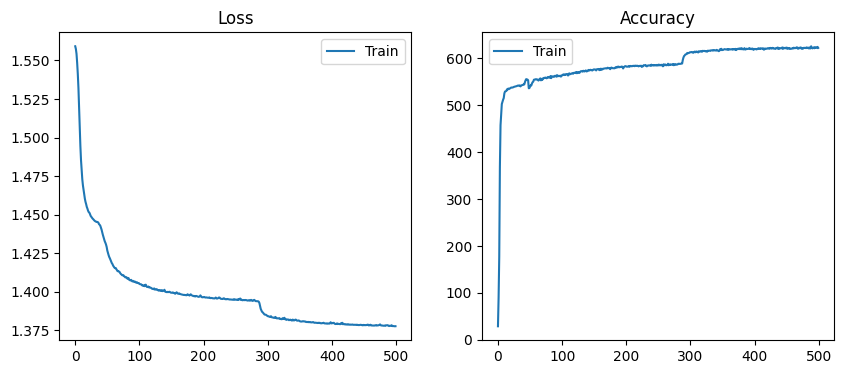

In [9]:
model = VanillaRNN(input_size, 32, 1)
trainer = Trainer(model, "adam", 1e-3, 128, 500, 1e-5)
trainer.train(data)

# generate 1000 strings & validation with the `validate` function
seqs = trainer.sample(1000)
validate(seqs)

There are 27 unique SMILES, and 13 valid and unique SMILES

## (c)

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x, h):
        # lstm
        out, h = self.lstm(x, h)
        # fc
        out = self.fc(out)
        # softmax
        out = self.softmax(out)
        return out, h
        
    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size), 
                torch.zeros(self.num_layers, batch_size, self.hidden_size))

Number of unique SMILES: 19
Number of valid & unique SMILES: 15


['C=CC=CC=N',
 'CC1CC1C',
 'C1CCC1',
 'C=CC1CC1',
 'CC1CC1N',
 'CC1CCC1',
 'C=CC1CCC1',
 'C=C1CCC1',
 'CC1CC1CN',
 'C=CC=CN',
 'C=CCC1CC1',
 'CC=CC1CC1',
 'C=CC1CC1C',
 'CC1C=CCC1',
 'CC1CC1']

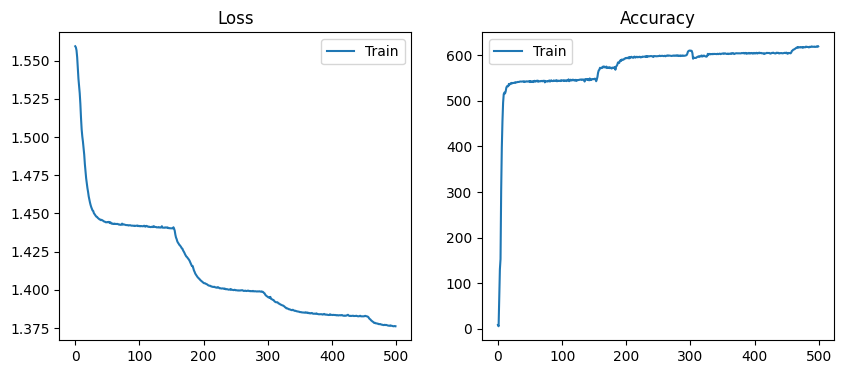

In [11]:
model = LSTM(input_size, 32, 1)
trainer = Trainer(model, "adam", 1e-3, 128, 500, 1e-5)
trainer.train(data)

# generate 1000 strings & validation with the `validate` function
seqs = trainer.sample(1000)
validate(seqs)

For LSTM, There are 19 unique SMILES, and 15 valid and unique SMILES